## Overview
This tutorial has been prepared by Alex Bonnet, ML Solutions Engineer @ Encord - you might also be interested in checking out our open-source framework for computer vision model testing, evaluation, and validation that you can find here https://github.com/encord-team/encord-active).

This is the notebook which implements the steps discussed in this blog post: https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/

The aim is to take Segment Anything Model and fine tune it to a specific application. We are going to be using the stamp verification dataset https://www.kaggle.com/datasets/rtatman/stamp-verification-staver-dataset since it has data SAM is unlikely to have seen (scans of invoices with stamps), has precise ground truth segmentation masks and also has bounding boxes which we can use as prompts to SAM.

## Set up

In [ ]:
from google.colab import drive
drive.mount('contents/')

Mounted at contents/


In [ ]:
!pwd

/content


In [ ]:
%cd /content/contents/MyDrive/인공지능시스템/proj/

/content/contents/MyDrive/인공지능시스템/proj


In [ ]:

! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

**Action Required:** Place your kaggle.json file into the files in the notebook workspace. More info here https://github.com/Kaggle/kaggle-api#api-credentials

In [ ]:
import os

lis1 = os.listdir('./data/images')
lis2 = os.listdir('./data/labels')


print(len(lis1))
print(len(lis2))

800
800


In [ ]:
lis1

['LC_AP_37607046_001.tif',
 'LC_AP_37607046_005.tif',
 'LC_AP_37607046_008.tif',
 'LC_AP_37607046_006.tif',
 'LC_AP_37607046_003.tif',
 'LC_AP_37607046_002.tif',
 'LC_AP_37607046_007.tif',
 'LC_AP_37607046_004.tif',
 'LC_AP_37607046_013.tif',
 'LC_AP_37607046_017.tif',
 'LC_AP_37607046_014.tif',
 'LC_AP_37607046_011.tif',
 'LC_AP_37607046_010.tif',
 'LC_AP_37607046_012.tif',
 'LC_AP_37607046_009.tif',
 'LC_AP_37607046_015.tif',
 'LC_AP_37607046_016.tif',
 'LC_AP_37607046_021.tif',
 'LC_AP_37607046_025.tif',
 'LC_AP_37607046_023.tif',
 'LC_AP_37607046_018.tif',
 'LC_AP_37607046_019.tif',
 'LC_AP_37607046_022.tif',
 'LC_AP_37607046_024.tif',
 'LC_AP_37607046_020.tif',
 'LC_AP_37607046_029.tif',
 'LC_AP_37607046_026.tif',
 'LC_AP_37607046_030.tif',
 'LC_AP_37607046_031.tif',
 'LC_AP_37607046_032.tif',
 'LC_AP_37607046_027.tif',
 'LC_AP_37607046_033.tif',
 'LC_AP_37607046_028.tif',
 'LC_AP_37607046_037.tif',
 'LC_AP_37607046_036.tif',
 'LC_AP_37607046_038.tif',
 'LC_AP_37607046_039.tif',
 

In [ ]:
lis2

['LC_AP_37607046_007_FGT.tif',
 'LC_AP_37607046_004_FGT.tif',
 'LC_AP_37607046_020_FGT.tif',
 'LC_AP_37607046_008_FGT.tif',
 'LC_AP_37607046_001_FGT.tif',
 'LC_AP_37607046_022_FGT.tif',
 'LC_AP_37607046_003_FGT.tif',
 'LC_AP_37607046_024_FGT.tif',
 'LC_AP_37607046_013_FGT.tif',
 'LC_AP_37607046_017_FGT.tif',
 'LC_AP_37607046_023_FGT.tif',
 'LC_AP_37607046_025_FGT.tif',
 'LC_AP_37607046_012_FGT.tif',
 'LC_AP_37607046_006_FGT.tif',
 'LC_AP_37607046_016_FGT.tif',
 'LC_AP_37607046_018_FGT.tif',
 'LC_AP_37607046_015_FGT.tif',
 'LC_AP_37607046_021_FGT.tif',
 'LC_AP_37607046_011_FGT.tif',
 'LC_AP_37607046_026_FGT.tif',
 'LC_AP_37607046_005_FGT.tif',
 'LC_AP_37607046_014_FGT.tif',
 'LC_AP_37607046_009_FGT.tif',
 'LC_AP_37607046_019_FGT.tif',
 'LC_AP_37607046_010_FGT.tif',
 'LC_AP_37607046_002_FGT.tif',
 'LC_AP_37607046_064_FGT.tif',
 'LC_AP_37607046_039_FGT.tif',
 'LC_AP_37607046_088_FGT.tif',
 'LC_AP_37607046_102_FGT.tif',
 'LC_AP_37607046_040_FGT.tif',
 'LC_AP_37607046_109_FGT.tif',
 'LC_AP_

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Exclude scans with zero or multiple bboxes (of the first 100)
stamps_to_exclude = {
    'stampDS-00008',
    'stampDS-00010',
    'stampDS-00015',
    'stampDS-00021',
    'stampDS-00027',
    'stampDS-00031',
    'stampDS-00039',
    'stampDS-00041',
    'stampDS-00049',
    'stampDS-00053',
    'stampDS-00059',
    'stampDS-00069',
    'stampDS-00073',
    'stampDS-00080',
    'stampDS-00090',
    'stampDS-00098',
    'stampDS-00100'
}.union({
    'stampDS-00012',
    'stampDS-00013',
    'stampDS-00014',
}) # Exclude 3 scans that aren't the type of scan we want to be fine tuning for

## Preprocess data

We extract the bounding box coordinates which will be used to feed into SAM as prompts.

In [ ]:
bbox_coords = {}
for f in sorted(Path('./data/labels/').iterdir()):
  k = f.stem
  if k not in stamps_to_exclude:
    im = cv2.imread(f.as_posix())
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    if len(contours) > 1:
      x,y,w,h = cv2.boundingRect(contours[0])
      height, width, _ = im.shape


      bbox_coords[k] = np.array([0, 0, 511, 511])

In [ ]:
bbox_coords

{'LC_AP_37607046_001_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_002_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_003_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_004_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_005_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_006_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_007_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_008_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_009_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_010_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_011_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_012_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_013_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_014_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_015_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_017_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_018_FGT': array([  0,   0, 511, 511]),
 'LC_AP_37607046_021_FGT': array([  0,   0, 511,

We extract the ground truth segmentation masks

In [ ]:
ground_truth_masks = {}
for k in bbox_coords.keys():
  gt_grayscale = cv2.imread(f'./data/labels/{k}.tif', cv2.IMREAD_GRAYSCALE)
  ground_truth_masks[k] = (gt_grayscale == 0)

In [ ]:
ground_truth_masks

{'LC_AP_37607046_001_FGT': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]),
 'LC_AP_37607046_002_FGT': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'LC_AP_37607046_003_FGT': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  

## Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [ ]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

We can see here that the ground truth mask is extremely tight which will be good for calculating an accurate loss.
The bounding box overlaid will be a good prompt.

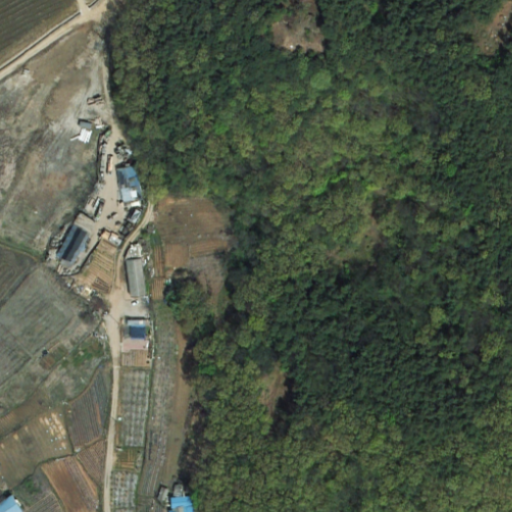

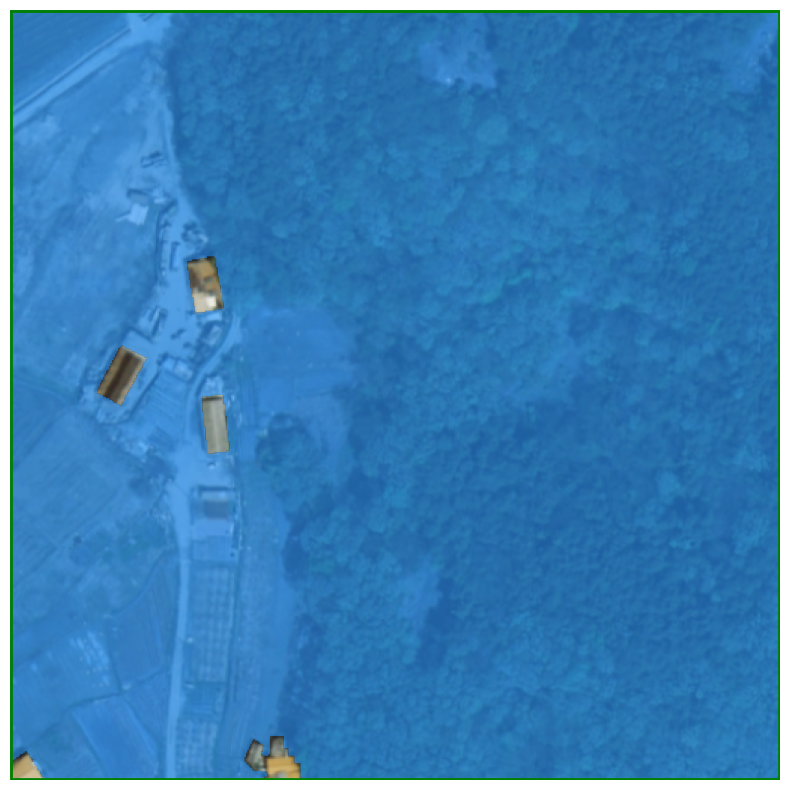

In [ ]:
from google.colab.patches import cv2_imshow
name = 'LC_AP_37607058_049'
image = cv2.imread(f'./data/images/{name[:]}.tif')
cv2_imshow(image)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name+'_FGT'], plt.gca())
show_mask(ground_truth_masks[name+'_FGT'], plt.gca())
plt.axis('off')
plt.show()

## Prepare Fine Tuning

In [ ]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [ ]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

We convert the input images into a format SAM's internal functions expect.

In [ ]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'./data/images/{k[:-4]}.tif')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size

In [ ]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())

## Run fine tuning

This is the main training loop.

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. Sometimes the optimizer gets lost in the parameter space and the loss function blows up. Restarting from scratch (including running all cells below 'Prepare Fine Tuning' in order to start with default weights again) will solve this.

In a production implementation a better choice of optimiser/loss function will certainly help.

In [ ]:
transformed_data

defaultdict(dict,
            {'LC_AP_37607046_001_FGT': {'image': tensor([[[[ 0.8789,  0.9132,  0.9646,  ..., -1.4672, -1.4500, -1.4500],
                        [ 0.7933,  0.8276,  0.8789,  ..., -1.4158, -1.3644, -1.3302],
                        [ 0.6049,  0.6392,  0.6906,  ..., -1.3302, -1.1760, -1.1075],
                        ...,
                        [ 1.4954,  1.4612,  1.4269,  ..., -0.3369, -0.1143, -0.0116],
                        [ 1.4954,  1.4783,  1.4440,  ..., -0.2513, -0.0287,  0.0741],
                        [ 1.4954,  1.4783,  1.4440,  ..., -0.1999,  0.0056,  0.1083]],
              
                       [[ 0.7829,  0.8004,  0.8529,  ..., -1.1779, -1.1078, -1.0728],
                        [ 0.6954,  0.7304,  0.7829,  ..., -1.1254, -1.0028, -0.9503],
                        [ 0.5378,  0.5728,  0.6429,  ..., -1.0028, -0.7927, -0.6877],
                        ...,
                        [ 1.7283,  1.6933,  1.6408,  ..., -0.0749,  0.1001,  0.1877],
             

In [ ]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 50
losses = []

for epoch in range(num_epochs):
  print('Epoch : ', epoch)
  epoch_losses = []
  # Just train on the first 20 examples
  for idx, k in enumerate(keys):
    print('Epoch : ', epoch, 'img : ', idx, '/', len(keys))
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)

      prompt_box = bbox_coords[k]
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch :  1 img :  412 / 649
Epoch :  1 img :  413 / 649
Epoch :  1 img :  414 / 649
Epoch :  1 img :  415 / 649
Epoch :  1 img :  416 / 649
Epoch :  1 img :  417 / 649
Epoch :  1 img :  418 / 649
Epoch :  1 img :  419 / 649
Epoch :  1 img :  420 / 649
Epoch :  1 img :  421 / 649
Epoch :  1 img :  422 / 649
Epoch :  1 img :  423 / 649
Epoch :  1 img :  424 / 649
Epoch :  1 img :  425 / 649
Epoch :  1 img :  426 / 649
Epoch :  1 img :  427 / 649
Epoch :  1 img :  428 / 649
Epoch :  1 img :  429 / 649
Epoch :  1 img :  430 / 649
Epoch :  1 img :  431 / 649
Epoch :  1 img :  432 / 649
Epoch :  1 img :  433 / 649
Epoch :  1 img :  434 / 649
Epoch :  1 img :  435 / 649
Epoch :  1 img :  436 / 649
Epoch :  1 img :  437 / 649
Epoch :  1 img :  438 / 649
Epoch :  1 img :  439 / 649
Epoch :  1 img :  440 / 649
Epoch :  1 img :  441 / 649
Epoch :  1 img :  442 / 649
Epoch :  1 img :  443 / 649
Epoch :  1 img :  444 / 649
Epoch :  1 img :  445 / 649
Epoch :  1 i

KeyboardInterrupt: ignored

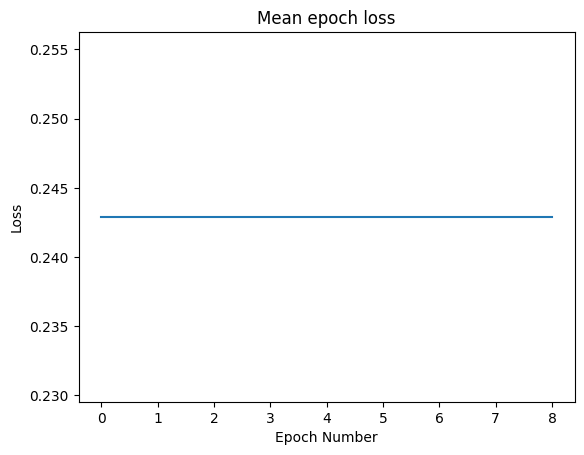

In [ ]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [ ]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [ ]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [ ]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = keys[21]
image = cv2.imread(f'./data/scans/scans/{k}.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

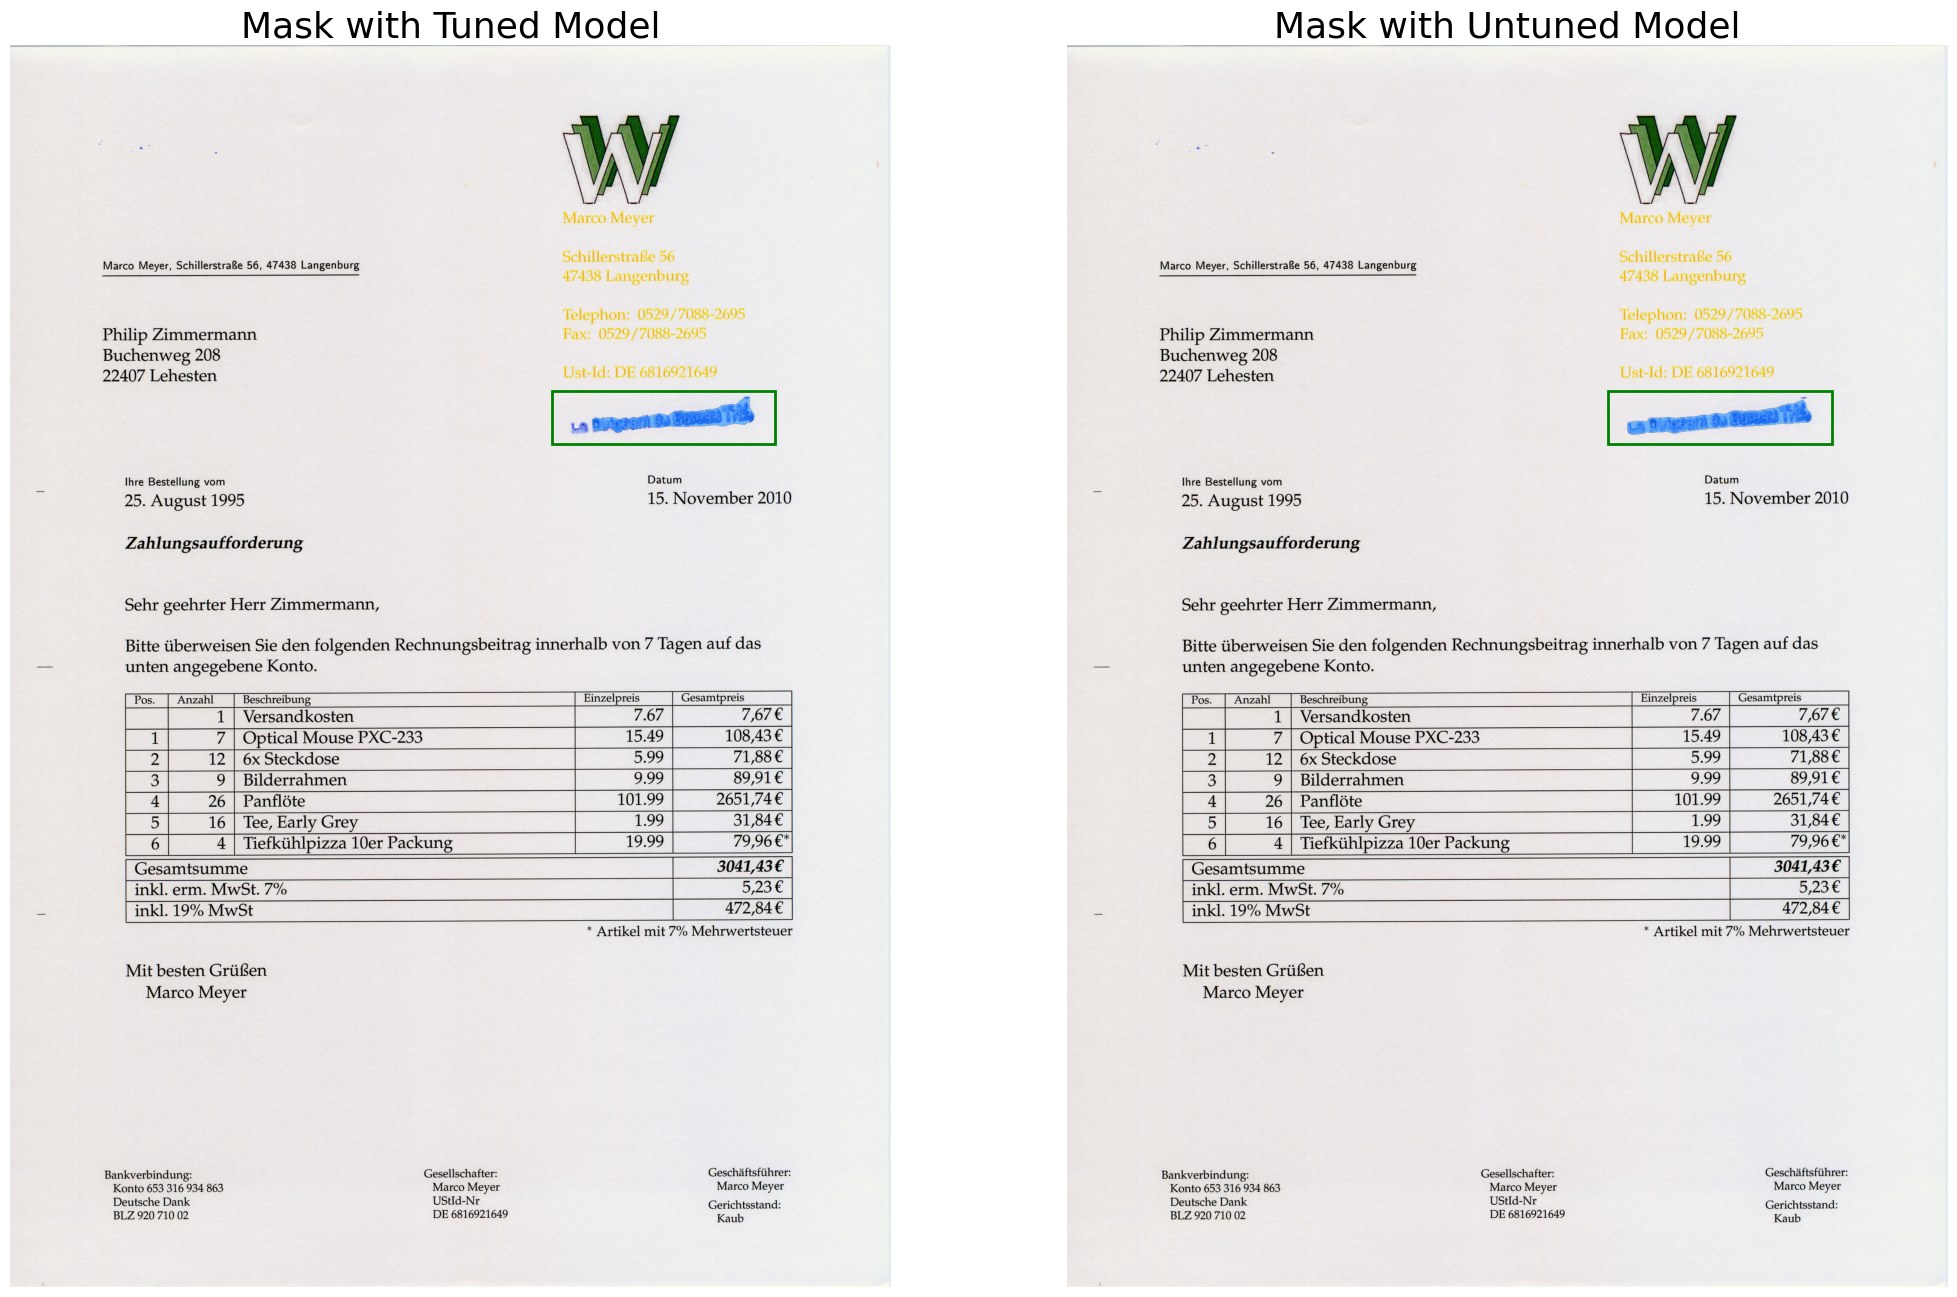

In [ ]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()